In [2]:
%pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

In [109]:
import pandas as pd
import cfe.regression as rgsn
import seaborn as sns
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
import matplotlib.pyplot as plt


In [4]:
US_Data = 'https://docs.google.com/spreadsheets/d/1q5aGdIXILMcY5AzwxwD9lnQa6dRnrOuAjvTJABGxHZs/edit?usp=sharing'

In [88]:
x = read_sheets(US_Data,sheet='Food Expenditures 2021')
p = read_sheets(US_Data, sheet = 'prices_adapted')
p = p[p['t'] == '2017/2018'][['t','j','m','price']]

In [89]:
p['price (kg)'] = p['price'] * 10
x['kg'] = x['grams']/1000

In [7]:
expenditures = x.merge(p, on = 'j', how = 'left')
droppedna = expenditures[~expenditures['t_y'].isna()]
droppedna['expenditure'] = droppedna['price (kg)'] * droppedna['kg']

/tmp/ipykernel_76/2196283929.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droppedna['expenditure'] = droppedna['price (kg)'] * droppedna['kg']


In [8]:
final = droppedna[['i', 't_x', 'm_x', 'expenditure', 'food_name']]
final = final.rename(columns = {'t_x':'t','m_x': 'm', 'expenditure': 'j'})

In [9]:
foods = final['food_name']
final['food_name'] = final['j']
final['j'] = foods

In [10]:
final = final.set_index(['i','t','m','j']).squeeze()

In [11]:
final.name = 'Expenditures'

In [12]:
y = np.log(final)

### Constructing D

In [16]:
d = read_sheets(US_Data,sheet="Household Characteristics 2021")

In [21]:
bins   = [0, 4,   8,    13,   18,   30,   50,   100]
labels = ['00-03','04-08','09-13','14-18','19-30','31-50','51-99']

d['age_group'] = pd.cut(d['age'], bins=bins, labels=labels, 
                         include_lowest=True, right=True)
d['sex_age'] = d['sex'] + 's ' + d['age_group'].astype(str)

In [23]:
reformatted = (
    d
    .pivot_table(
        index=['i','t','m'],
        columns='sex_age',
        aggfunc='size',
        fill_value=0
    )
    .rename_axis(None, axis=1)
    .reset_index()
)

In [29]:
d = reformatted.set_index(['i','t','m'])

In [37]:
dups = y.index.duplicated(keep=False)

# how many dups
print(dups.sum())

print(y[dups].head(10))
# drop the doops
y = y[~y.index.duplicated(keep='first')]

41
i       t     m    j                                                           
130564  2021  USA  Peanut butter and jelly sandwich, with regular peanut butter   -0.514977
                   Peanut butter and jelly sandwich, with regular peanut butter   -0.412155
130880  2021  USA  Egg omelet or scrambled egg, with cheese, meat, and vegetabl    0.532027
                   Egg omelet or scrambled egg, with cheese, meat, and vegetabl    0.494727
131177  2021  USA  Bread, white, made from home recipe or purchased at a bakery   -1.547193
                   Bread, white, made from home recipe or purchased at a bakery   -1.547193
131277  2021  USA  Peanut butter and jelly sandwich, with regular peanut butter   -1.226397
                   Peanut butter and jelly sandwich, with regular peanut butter   -1.121778
131458  2021  USA  Peanut butter and jelly sandwich, with regular peanut butter   -0.533250
                   Peanut butter and jelly sandwich, with regular peanut butter   -0.5149

### lets filter y down to manage regression size

In [41]:
#total spend per food
food_totals = final.groupby(level='j').sum()

# top 500 foods
top500 = food_totals.nlargest(500).index
# filter
final_top500 = final[ final.index.get_level_values('j').isin(top500) ]

y_top500 = y[ y.index.get_level_values('j').isin(top500) ]

In [42]:
rfinal = rgsn.Regression(y=y_top500, d=d, 
                    min_obs=10, min_prop_items=0.002)

In [43]:
rfinal.to_pickle('final_expenditure_rgsn')

In [163]:
nut = read_sheets(US_Data,sheet='nutrient_adapted')
nut *=10
nut = nut.set_index('j')
nut.columns.name = 'n'

nut = nut.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [175]:
rdi = read_sheets(US_Data,sheet='rdi')

rdi = rdi.set_index('n')
rdi.columns.name = 'k'

rdi = rdi.apply(lambda x: pd.to_numeric(x,errors='coerce')).drop(columns = ['Nutrient Type', 'Unit', 'Constraint Type'])
rdisave = rdi.copy()

In [60]:
xhat = rfinal.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

In [85]:
expfoods = read_sheets(US_Data, sheet = 'Food Expenditures 2021')
expfoods = expfoods[['j', 'food_name']]
expfoods

,j,food_name
0,13110102,"Ice cream, vanilla, with additional ingredients"
1,14108010,"Cheese, parmesan, dry grated"
2,24100000,"Chicken, ns as to part and cooking method, ns ..."
3,24100020,"Chicken, ns as to part and cooking method, ski..."
4,26137123,"Fish, salmon, grilled"
...,...,...
141099,92101000,"Coffee, brewed"
141100,93301110,Martini
141101,93401010,"Wine, red"
141102,93505000,Vodka


In [90]:
p = p.merge(expfoods, on = 'j', how = 'left').drop(columns = ['j']).rename(columns = {'food_name': 'j'})

In [94]:
p_j = (
    p
    .groupby('j')['price (kg)']   # group on the food‐name column
    .mean()                       # average over any t, m duplicates
)
missing = set(rfinal.beta.index) - set(p_j.index)
print("Foods in your regression not found in p:", missing)

Foods in your regression not found in p: set()


### Food quantities

In [96]:
pbar = (
  p_j
    .reindex(rfinal.beta.index)   # now p_j.index == food_name
    .fillna(1)
)

In [97]:

qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,"Apple, raw","Avocado, raw","Banana, raw","Blueberries, raw","Butter, stick","Butter, tub","Cantaloupe, raw","Carrots, raw","Cereal, granola","Cheese, cheddar",...,"Strawberries, raw","Tea, hot, leaf, black","Tomatoes, for use on a sandwich","Tomatoes, raw","Tortilla chips, plain","Water, bottled, plain","Water, carbonated, flavored","Water, tap","Watermelon, raw","Wine, red"
i,t,m,,,,,,,,,,,,,,,,,,,,,
130378,2021,USA,0.174534,0.067760,0.126004,0.062225,0.008994,0.010299,0.061643,0.036802,0.052695,0.032209,...,0.070695,0.353085,0.023880,0.062682,0.035631,1.563607,0.494358,1.594555,0.120077,0.276930
130379,2021,USA,0.280235,0.152636,0.173312,0.123012,0.022358,0.026569,0.240691,0.083538,0.143481,0.068599,...,0.162030,0.422584,0.036943,0.152952,0.090804,1.352895,0.761628,1.341462,0.923906,0.330645
130380,2021,USA,0.126800,0.044108,0.092787,0.039245,0.006137,0.006601,0.058438,0.023775,0.026769,0.021863,...,0.042278,0.410934,0.016877,0.041458,0.020276,1.300682,0.373435,1.280782,0.046861,0.152358
130381,2021,USA,0.132507,0.048916,0.111631,0.036087,0.007339,0.006256,0.129166,0.050041,0.045050,0.045578,...,0.090049,0.220389,0.016856,0.063680,0.030134,0.642877,0.207982,0.635418,0.205511,0.225469
130382,2021,USA,0.196443,0.081296,0.137263,0.102146,0.009791,0.014520,0.180202,0.060090,0.043802,0.045822,...,0.127514,0.324547,0.026532,0.158318,0.048048,0.444121,0.589892,0.564855,0.671622,0.315621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142303,2021,USA,0.097051,0.034546,0.074326,0.026521,0.005517,0.004922,0.040515,0.015166,0.025360,0.014994,...,0.035982,0.402064,0.014308,0.031170,0.013487,0.896760,0.314412,0.838015,0.032054,0.147305
142304,2021,USA,0.155991,0.039205,0.111912,0.094440,0.007428,0.009119,0.089305,0.041998,0.035173,0.049028,...,0.077043,0.359127,0.020917,0.037901,0.018852,1.167029,0.320055,1.183649,0.132549,0.183308
142307,2021,USA,0.212055,0.099208,0.137014,0.088073,0.011758,0.014301,0.135957,0.061052,0.056563,0.046608,...,0.099189,0.435312,0.025780,0.093732,0.046766,1.584417,0.572010,1.742984,0.260259,0.224853


In [98]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

In [99]:
%matplotlib inline

In [164]:
def singledemandcurve(item): 
    use = item  # Good we want demand curve for
    
    # Vary prices from 50% to 200% of reference.
    scale = np.linspace(.5,2,20)
    
    # Demand for Matoke for household at median budget
    plt.plot([rfinal.demands(xref,my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)
    
    # Demand for Matoke for household at 25% percentile
    plt.plot([rfinal.demands(xbar.quantile(0.25),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)
    
    # Demand for Matoke for household at 75% percentile
    plt.plot([rfinal.demands(xbar.quantile(0.75),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)
    
    plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
    plt.xlabel(f"Quantities of {use} Demanded")

/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.22E-04.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -4.77E-07.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -2.33E-10.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps toleranc

Text(0.5, 1.0, 'Engel Curves')

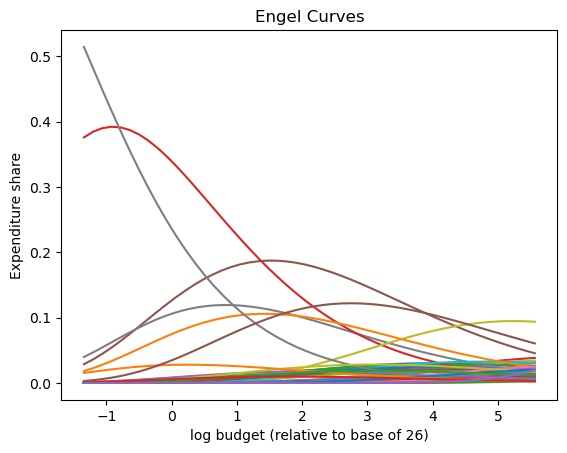

In [165]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[rfinal.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to nutrients

In [166]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = nut.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index([], dtype='object', name='j')


In [167]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i,130378,130379,130380,130381,130382,130386,130387,130389,130390,130392,...,142298,142299,142300,142301,142302,142303,142304,142307,142309,142310
t,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,...,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
m,USA,USA,USA,USA,USA,USA,USA,USA,USA,USA,...,USA,USA,USA,USA,USA,USA,USA,USA,USA,USA
n,,,,,,,,,,,,,,,,,,,,,
Calcium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Carbohydrate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cholesterol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dietary Fiber,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Folate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Iron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
def nutrient_demand(x,p):
    c = rfinal.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = geta

Text(0, 0.5, 'log nutrient')

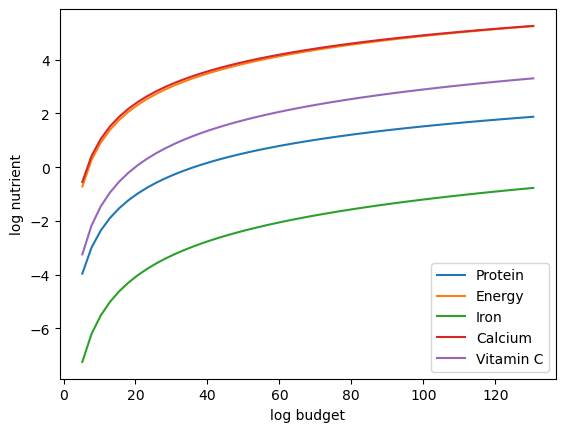

In [169]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = geta

Text(0, 0.5, 'log nutrient')

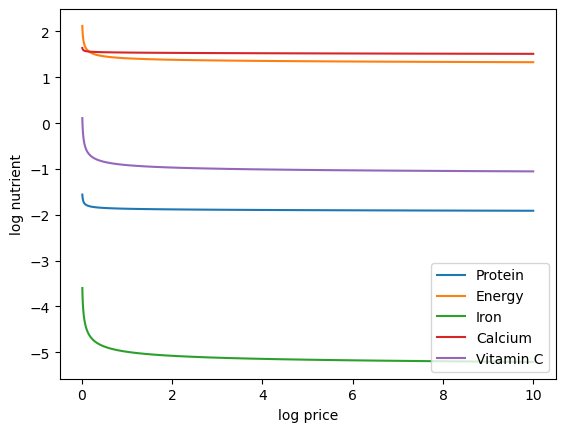

In [170]:
USE_GOOD = 'Blueberries, raw'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households

In [176]:
rename_map = {
    'Child_1_3':    'Children 00-03',
    'Female_4_8':   'Females 04-08',
    'Male_4_8':     'Males 04-08',
    'Female_9_13':  'Females 09-13',
    'Male_9_13':    'Males 09-13',
    'Female_14_18': 'Females 14-18',
    'Male_14_18':   'Males 14-18',
    'Female_19_30': 'Females 19-30',
    'Male_19_30':   'Males 19-30',
    'Female_31_50': 'Females 31-50',
    'Male_31_50':   'Males 31-50',
    'Female_51U':   'Females 51-99',
    'Male_51U':     'Males 51-99',
}

rdi = rdisave.rename(columns=rename_map)
if 'Children 00-03' in rdi.columns:
    rdi['Females 00-03'] = rdi['Children 00-03']
    rdi['Males 00-03'] = rdi['Children 00-03']

# and then drop the orphan column if you like
rdi = rdi.drop(columns=['Children 00-03'])


In [177]:
dbar = rfinal.d[rdi.columns].mean()

In [178]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi@dbar

hh_rdi

n
Energy            1780.556386
Protein             44.744391
Carbohydrate       130.000000
Dietary Fiber       24.927789
Linoleic Acid       12.341310
Linolenic Acid       1.240413
Calcium           1115.704457
Iron                 9.981304
Magnesium          322.295842
Phosphorus         751.811247
Potassium         4522.210589
Sodium            2217.424469
Zinc                 8.600658
Copper               0.820147
Selenium            50.110679
Vitamin A          719.727789
Vitamin E           13.630123
Vitamin D           15.000000
Vitamin C           70.295393
Thiamin              1.047966
Riboflavin           1.083578
Niacin              13.682321
Vitamin B6           1.310694
Vitamin B12          2.185298
Choline            439.747233
Vitamin K           90.361950
Folate             364.216273
dtype: float64

In [179]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -2.38E-07.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.19E-07.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.16E-10.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps toleranc

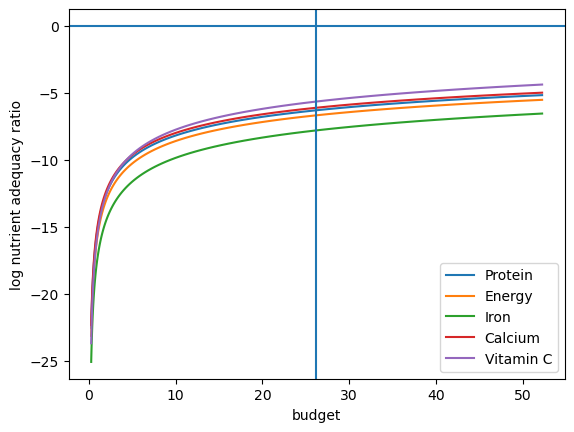

In [180]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.82E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.82E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.82E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps toleranc

Text(0.5, 0, 'log nutrient adequacy ratio')

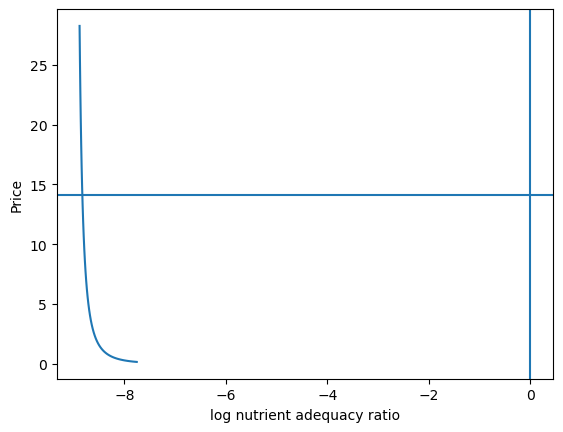

In [181]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(USE_GOOD,pbar[USE_GOOD]*s),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin C'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

In [183]:
print("RDI columns:", rdi.columns.tolist())
print("RDI sample:\n", rdi.head())

RDI columns: ['Females 04-08', 'Males 04-08', 'Females 09-13', 'Males 09-13', 'Females 14-18', 'Males 14-18', 'Females 19-30', 'Males 19-30', 'Females 31-50', 'Males 31-50', 'Females 51-99', 'Males 51-99', 'Females 00-03', 'Males 00-03']
RDI sample:
 k              Females 04-08  Males 04-08  Females 09-13  Males 09-13  \
n                                                                       
Energy                1200.0       1400.0         1600.0       1800.0   
Protein                 19.0         19.0           34.0         34.0   
Carbohydrate           130.0        130.0          130.0        130.0   
Dietary Fiber           16.8         19.6           22.4         25.2   
Linoleic Acid           10.0         10.0           10.0         12.0   

k              Females 14-18  Males 14-18  Females 19-30  Males 19-30  \
n                                                                       
Energy                1800.0       2200.0         2000.0       2400.0   
Protein           

In [ ]:
class PolicySimulator:
    def __init__(self, rfinal, pbar, fct, rdi):
        # … your existing init …
        # PRECOMPUTE a “trimmed” nutrient‐composition matrix:
        self.j_index = pbar.index
        # only keep the rows in fct that match your items j
        self.fct0 = fct.loc[self.j_index].copy()
        # also store its transpose for fast numpy dot later
        self.fct0T = self.fct0.values.T    # shape (nutrients × j)
    
    def _build_price_vector(self, price_shocks, nutrient_taxes):
        """
        price_shocks : Series(index=j) multiplicative factors (1=no change)
        nutrient_taxes: Series(index=nutrient) $ per kg of that nutrient
        """
        # start with multiplicative
        p_new = self.pbar * price_shocks.reindex(self.pbar.index).fillna(1.)
        # add on nutrient‐tax pass‐through: ∑ tax[n]*fct[j,n]
        if nutrient_taxes is not None:
            tax = (self.fct.mul(nutrient_taxes, axis=1)).sum(axis=1)
            p_new += tax
        return p_new
    
    def _build_fct(self, nutrient_mods):
        """
        nutrient_mods : DataFrame(index=j,cols=nutrient) additive shifts (e.g. GM boost)
        """
        if nutrient_mods is None:
            return self.fct
        return (self.fct + nutrient_mods).clip(lower=0)
    
    def run(self,
            price_shocks: pd.Series=None,
            nutrient_taxes: pd.Series=None,
            nutrient_mods: pd.DataFrame=None,
            income_scale: float=1.0,
            nutrients: list=None):
        """
        Executes one policy scenario and returns a dict of intermediate results.
        
        Parameters
        ----------
        price_shocks : pd.Series, optional
            Multiplicative factors on baseline prices (index = j).
        nutrient_taxes : pd.Series, optional
            Additive $/kg tax on each nutrient (index = nutrient names).
        nutrient_mods : pd.DataFrame, optional
            Additive nutrient mods per food (index = j, columns = nutrients).
        income_scale : float, default 1.0
            Scale factor on baseline household budgets.
        nutrients : list of str, optional
            Subset of nutrient names to keep in the adequacy output.
        
        Returns
        -------
        dict with keys:
          - xhat: predicted expenditures (Series i,t,m,j)
          - qhat: predicted quantities (DataFrame (i,t,m) × j)
          - N: nutrient intake matrix (DataFrame nutrient × household)
          - adequacy: adequacy ratios (DataFrame household × nutrient)
          - budgets: scaled budgets (Series i,t,m)
          - prices: new price vector p_new (Series j)
        """
        # 1) build new price vector
        if price_shocks is None:
            price_shocks = pd.Series(1.0, index=self.pbar.index)
        p_new = self._build_price_vector(price_shocks, nutrient_taxes)

        # 2) build modified FCT
        fct_new = self._build_fct(nutrient_mods)

        # 3) scale budgets
        budgets = self.budgets0 * income_scale

        # 4a) get predicted budget‐shares at new prices
        shares = self.rfinal.predicted_shares(prices=p_new)

        # 4b) turn those shares into $ expenditures
        xhat_df = shares.mul(budgets, axis=0)
        xhat    = xhat_df.stack().rename("Expenditure")

        # 5) quantities in kg
        qhat = xhat_df.div(p_new, axis=1).dropna(how='all')


        # 6) compute nutrient intake: N = fct_newᵀ × qhatᵀ
        fct0, q0 = fct_new.align(qhat.T, join='inner', axis=0)
        N = fct0.T.dot(q0)

        # 7) transpose to household × nutrient
        ndf = N.T
        ndf.index.names = ['i','t','m']

        # 8) adequacy ratios
        adequacy = ndf.divide(self.rdi, axis=1)
        if nutrients is not None:
            adequacy = adequacy[nutrients]

        return {
            'xhat':       xhat,
            'qhat':       qhat,
            'N':          N,
            'adequacy':   adequacy,
            'budgets':    budgets,
            'prices':     p_new
            }
    
    # ---- now a few plotting helpers ----
    
    def plot_nutrient_adequacy(self, adequacy, ax=None):
        ax = ax or plt.gca()
        adequacy.mean().plot.bar(ax=ax)
        ax.set_ylabel("Mean adequacy ratio")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        return ax
    
    def plot_log_adequacy_curves(self, adequacy, ax=None):
        ax = ax or plt.gca()
        for nut in adequacy.columns:
            ax.plot(np.sort(np.log1p(adequacy[nut])), label=nut)
        ax.legend()
        ax.set_xlabel("Households (sorted)")
        ax.set_ylabel("log(1+adequacy)")
        plt.tight_layout()
        return ax
    
    def plot_engel_curves(self, xhat, budgets, ax=None):
        """
        Engel curves: share of budget spent on each food category
        vs. total budget
        """
        ax = ax or plt.gca()
        # pick a few example foods or aggregate categories
        # here we do top 5 by avg share
        shares = xhat.unstack('j').div(budgets, axis=0)
        top5 = shares.mean().nlargest(5).index
        for j in top5:
            ax.plot(budgets.sort_values(), 
                    shares.loc[budgets.sort_index(), j].sort_values(), 
                    label=j)
        ax.legend()
        ax.set_xlabel("Total budget")
        ax.set_ylabel("Budget share")
        plt.tight_layout()
        return ax
    
    def simulate_and_plot(self, **kwargs):
        """
        Convenience wrapper: runs run(**kwargs) then makes all 3 plots.
        """
        out = self.run(**kwargs)
        fig, axes = plt.subplots(3,1,figsize=(6,12))
        self.plot_nutrient_adequacy( out['adequacy'], ax=axes[0] )
        self.plot_log_adequacy_curves( out['adequacy'], ax=axes[1] )
        self.plot_engel_curves( out['xhat'], out['budgets'], ax=axes[2] )
        plt.show()
        return out


In [ ]:
# 1) Instantiate with your calibrated objects
sim = PolicySimulator(rfinal, pbar, fct, rdi)

# 2) Define shocks:
#   a) 10% across‐the‐board price increase:
shock = pd.Series(1.10, index=pbar.index)

#   b) $0.50/kg tax on sugar (nutrient name “Sugar” in your fct columns):
ntax = pd.Series({'Sugar': 0.5})

#   c) nutrient boost: add 2 g extra Protein to every food
nmod = pd.DataFrame(2.0, index=pbar.index, columns=['Protein'])

# 3) Run & plot
out = sim.simulate_and_plot(
    price_shocks=shock,
    nutrient_taxes=ntax,
    nutrient_mods=nmod,
    income_scale=1.2,
    nutrients=['Protein','Energy','Iron','Calcium']
)